# Analyzing ECoG Signals from Dataset 4 of the BCI Competition
<hr>



The goal of this element of the competition is to predict the flexion of individual fingers from signals recorded from the surface of the brain (electrocorticography (**ECoG**)). This data set contains
brain signals from three subjects, as well as the time courses of the flexion of each of five fingers.
The task in this competition is to use the provided flexion information in order to **predict** finger flexion for a provided test set. The performance of the classifier will be evaluated by calculating the average correlation coefficient r between actual and predicted finger flexion.

<br>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import matplotlib as plt
%matplotlib inline

In [4]:
print(keras.__version__)

2.6.0


In [5]:
# For the baseline correction #
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.fftpack import fftfreq, irfft, rfft

In [6]:
import scipy.io

sub1 = scipy.io.loadmat('sub1_comp.mat')
# sub2 = scipy.io.loadmat('sub2_comp.mat')
# sub3 = scipy.io.loadmat('sub3_comp.mat')

print(sub1.keys())

print(sub1['train_data'].shape, sub1['test_data'].shape, sub1['train_dg'].shape)
# print(sub2['train_data'].shape, sub2['test_data'].shape, sub2['train_dg'].shape)
# print(sub3['train_data'].shape, sub3['test_data'].shape, sub3['train_dg'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'train_data', 'test_data', 'train_dg'])
(400000, 62) (200000, 62) (400000, 5)


In [7]:
sub1_eval = scipy.io.loadmat('sub1_testlabels.mat')
print(sub1_eval.keys())

dict_keys(['__header__', '__version__', '__globals__', 'test_dg'])


<br>

So from above we can see the amount of data to be processed
Each of the training datasets were measured for 400 seconds (6mins 40s) sampled at 1000Hz, giving 400000 samples in total from the channels
Subject 1 has 62 channels of ECoG recordings, Subject 2 has 48 and Subject 3 has 64.

An important thing to notice is that the finger trajectory data has 400000 values even though it was sampled at a rate of 25 Hz, meaning only 10000 values. This means that the original finger trajectory data was upsampled to 1000 Hz.

<br>

In [8]:
print(sub1['train_data']) # Numerical look of the data of the ECoG signals

[[  193  -491 -4293 ...  1827  3096  2395]
 [   96  -451 -4419 ...  1794  3120  2497]
 [  329  -272 -4380 ...  1668  3236  2569]
 ...
 [ 1047  -588  1257 ...  3559  2951  1856]
 [  841  -834   962 ...  3342  2703  2135]
 [  672 -1009   563 ...  3131  2515  2187]]


In [9]:
print(sub1['train_dg']) #Numerical look of the finger movements

[[-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 [-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 [-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 ...
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]]


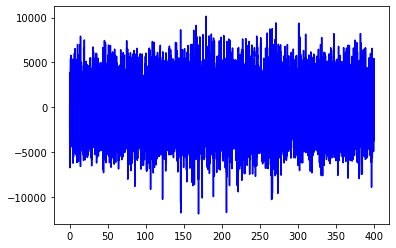

In [10]:
#print(sub1['train_data'][:, 0]) #channel 1 temporal data of ECoG signals from Subject 1

time = np.linspace(0, 400, 400000)
plt.pyplot.plot(time, sub1['train_data'][:, 0], 'b')

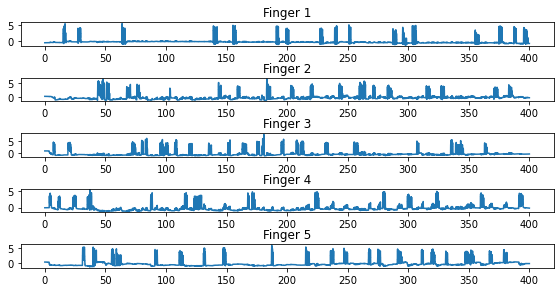

In [11]:
fig_fingers, axes = plt.pyplot.subplots(figsize = (8,4), nrows = 5, ncols = 1)
plt.pyplot.tight_layout()
axes[0].set_title('Finger 1')
axes[0].plot(time, sub1['train_dg'][:, 0])
axes[1].set_title('Finger 2')
axes[1].plot(time, sub1['train_dg'][:, 1])
axes[2].set_title('Finger 3')
axes[2].plot(time, sub1['train_dg'][:, 2])
axes[3].set_title('Finger 4')
axes[3].plot(time, sub1['train_dg'][:, 3])
axes[4].set_title('Finger 5')
axes[4].plot(time, sub1['train_dg'][:, 4])

The Cell below shows tries to visualize one of the channel's output correspoding to the movement of one of the fingers. This output is all from the first subject only. A 5 second window is considered and the first 55 seconds of the experiment are output. If you do not see a correlation or a pattern between the fingers flexionn and the ECoG signal from the first channel, it might be because these are not discernible to our human eyes. There are also 61 more channels to look at, corresponding to different centres in the brain.

In [12]:
# i = 0
# for i in range(0, 55, 5):
#     fig, axes = plt.pyplot.subplots(figsize = (10,4), nrows=1, ncols = 2)
    
#     time_axis = np.linspace(i, i+5, 5000)
#     ychannel = sub1['train_data'][i*1000:i*1000+5000, 0]
#     yfinger = sub1['train_dg'][i*1000:i*1000+5000, 0]
    
#     axes[1].set_ylim([-0.5, 5])
    
#     axes[0].plot(time_axis, ychannel, 'r')
#     axes[1].plot(time_axis, yfinger, 'b')
#     plt.pyplot.pause(1)

<br>

# Preprocessing
<hr>

Some methods I compiled that may be used to preprocess the signals:
1. Remove channels 51 of subject 1, channel 21 and 38 of subject 2 and channel 49 of subject 3
2. Baseline Drift correction of finger/make negative values 0
3. Apply an averaging filter on the finger data or threshold the in-between values in the finger data. Maybe we can use a 1-D Gaussian filter of maybe size 1001? and convolve with the signal with stride=1.
4. Create the 3 band specific ECoG signals (sub-band, gamma bad and fast gamma band), _Sanchez et al._ using equiripple finite pulse response
5. Amplitude Modulation

<br>

In [13]:
## Removing the noisy ECoG channels ##
sub1['train_data'] = np.delete(sub1['train_data'], 50, 1)
print(sub1['train_data'].shape)

# sub2['train_data'] = np.delete(sub2['train_data'], [20, 37], 1)
# print(sub2['train_data'].shape)

# sub3['train_data'] = np.delete(sub3['train_data'], 48, 1)
# print(sub3['train_data'].shape)

(400000, 61)


In [14]:
sub1['test_data'] = np.delete(sub1['test_data'], 50, 1)

In [15]:
## Applying baseline correction ##
# Alogrithm from paper on Baseline Correction using Asymmetric Least Squares Smoothing, P. Eilers and H.Boelens #

# 1st - baseline drift correction
# 2nd - normalize
# 3rd - set negative values to 0


def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# The second processing technique
def process2(finger):
    new_finger = baseline_als(finger, 100000, 0.05) # lamda set to 1e5 and p set to 0.05(>0.001 and <0.1)
    
    # Normalizing the array
    maxElement = np.amax(new_finger)
    new_finger /= maxElement
    
    # Threseholding the signal to have no negative value
    new_finger[new_finger < 0] = 0
    
    return new_finger
    

# i = 0
#iterating over all fingers for a particular subject

# fig_fingers, axes = plt.pyplot.subplots(figsize = (8,4), nrows = 5, ncols = 1)
# plt.pyplot.tight_layout()

# for i in range(0, 5):
#     new_finger = process2(sub1['train_dg'][:, i]) # Change the assignment to sub1['train_dg'] later
#     x = np.linspace(0, 10, 10000)

#     axes[i].set_title("Finger {n}".format(n = i))
#     axes[i].plot(sub1['train_dg'][:, i])
#     axes[i].plot(new_finger)
    

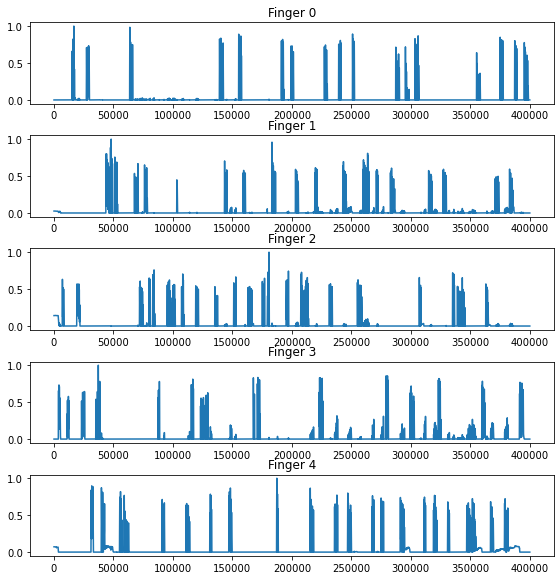

In [16]:
## Applying the correction to all the fingers ##
## We also apply a binary activation on the finger data, so that we can create the target vector ##

fig_fingers, axes = plt.pyplot.subplots(figsize = (8,8), nrows = 5, ncols = 1)
plt.pyplot.tight_layout()
for i in range(0, 5):
    sub1['train_dg'][:, i] = process2(sub1['train_dg'][:, i])
    
    axes[i].set_title("Finger {n}".format(n = i)) # 0-thumb, 1-index, 2-middle ....
    axes[i].plot(sub1['train_dg'][:, i])

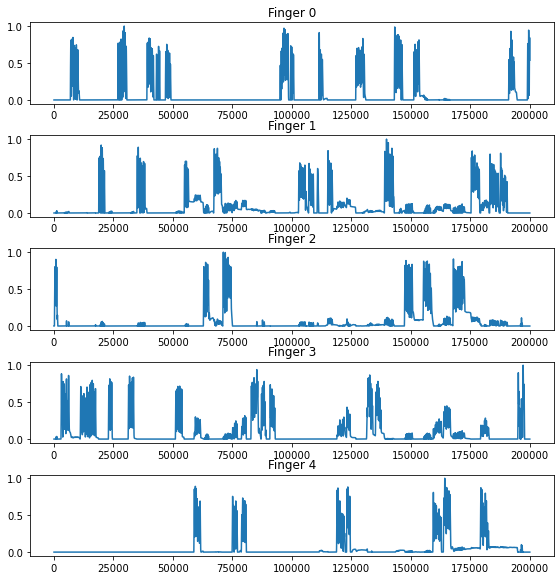

In [17]:
i = 0
fig_fingers, axes = plt.pyplot.subplots(figsize = (8,8), nrows = 5, ncols = 1)
plt.pyplot.tight_layout()
for i in range(0, 5):
    sub1_eval['test_dg'][:, i] = process2(sub1_eval['test_dg'][:, i])
    axes[i].set_title("Finger {n}".format(n = i)) # 0-thumb, 1-index, 2-middle ....
    axes[i].plot(sub1_eval['test_dg'][:, i])

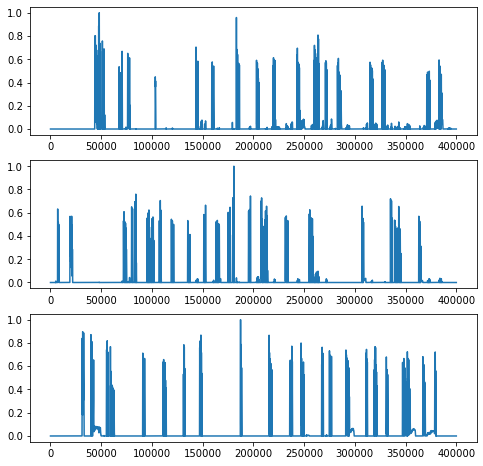

In [18]:
# Manually cleaning the beginning of the signals
sub1['train_dg'][0:10000, 1] = 0
sub1['train_dg'][0:5000, 2] = 0
sub1['train_dg'][0:10000, 4] = 0
sub1['train_dg'][380000:400000, 4] = 0

fig_fingers, axes = plt.pyplot.subplots(figsize = (8,8), nrows = 3, ncols = 1)
axes[0].plot(sub1['train_dg'][:, 1])
axes[1].plot(sub1['train_dg'][:, 2])
axes[2].plot(sub1['train_dg'][:, 4])

In [19]:
def binary_activation(signal, threshold):
    i=0
    len = signal.shape[0]
    binary_signal = np.zeros(len)
    stride = 2000
    
    for i in range(0, len-stride, stride): #timestep of 1 second
        if np.sum(signal[i:i+stride]) > threshold:
            binary_signal[i:i+stride] = 0.5
        
    return binary_signal
    

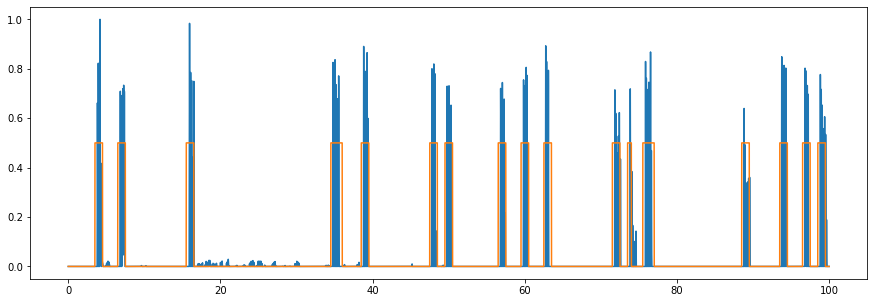

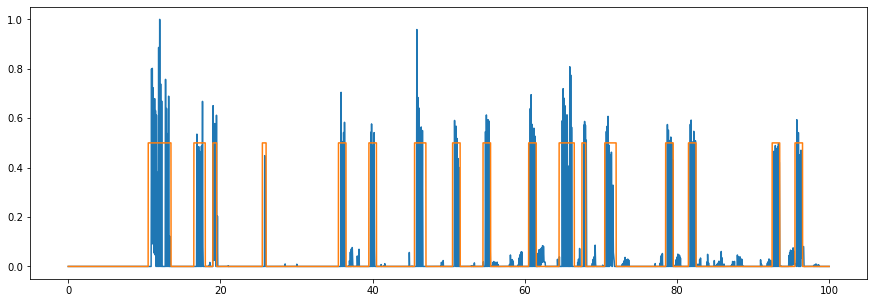

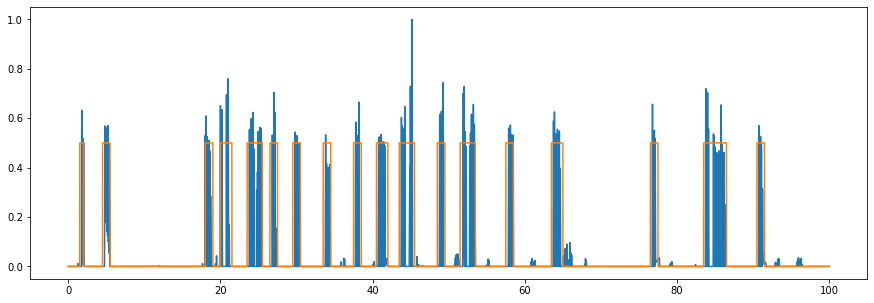

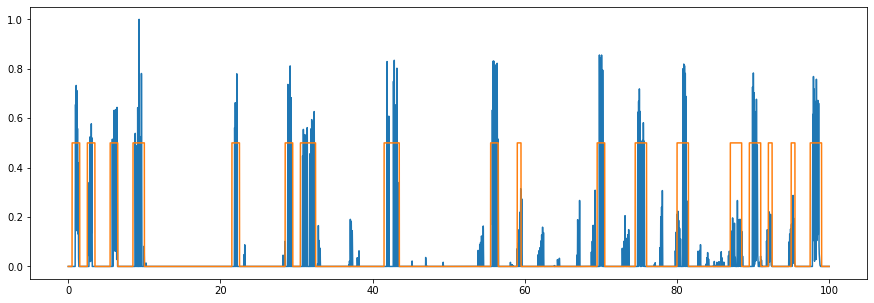

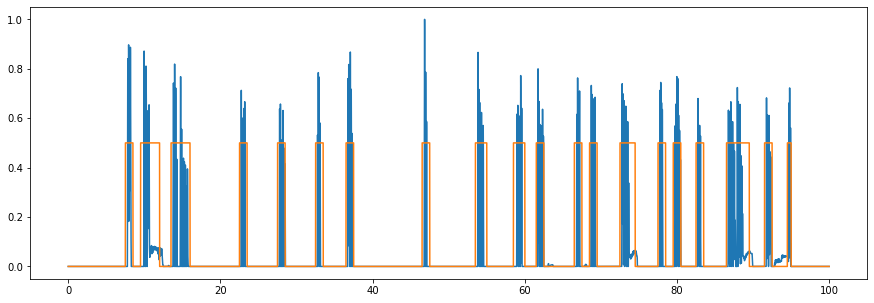

In [20]:
j = 0
binary_signal = np.zeros(sub1['train_dg'].shape)
for j in range(0,5):
    binary_signal[:, j] = binary_activation(sub1['train_dg'][:, j], threshold=100)
    
    fig = plt.pyplot.figure(figsize=(15,5))
    x = np.linspace(0, 100, 400000)
    plt.pyplot.plot(x, sub1['train_dg'][:, j])
    plt.pyplot.plot(x, binary_signal[:, j])

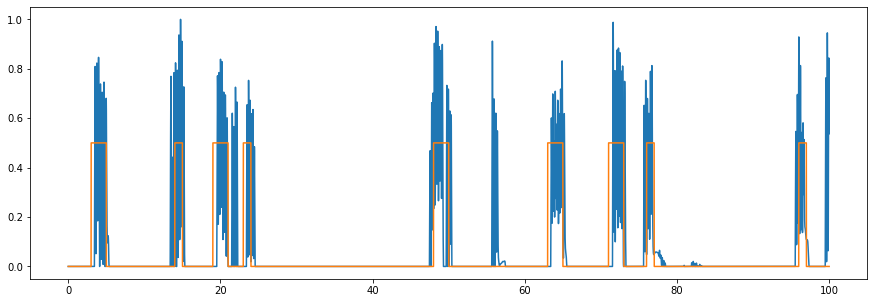

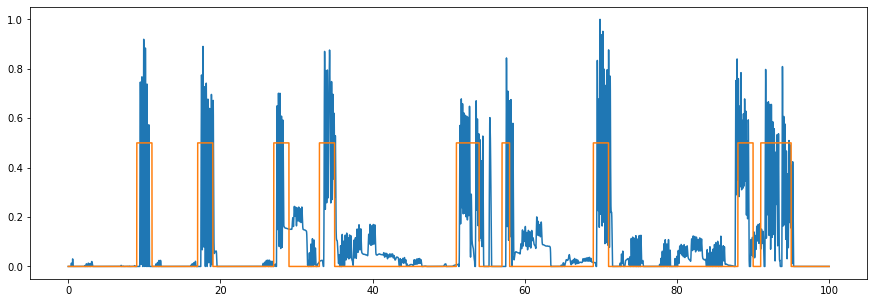

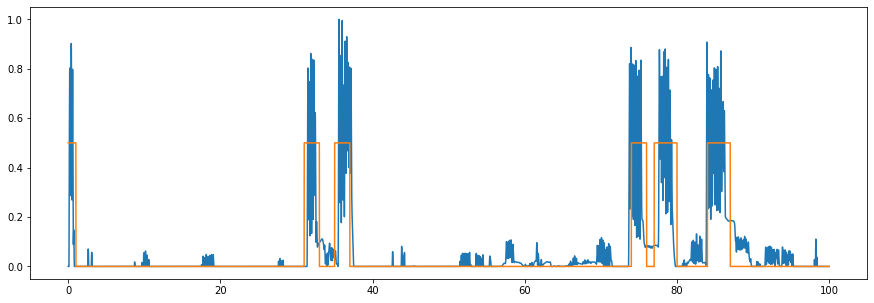

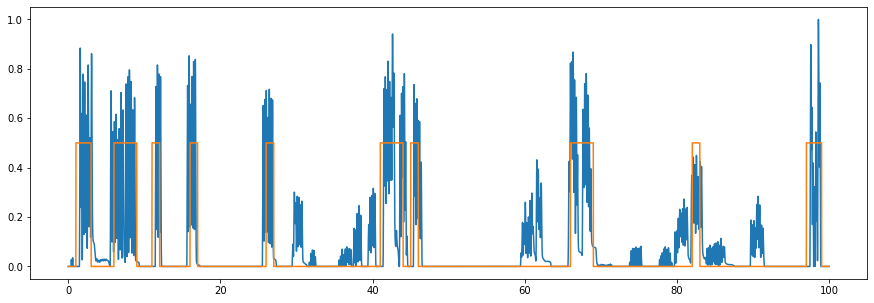

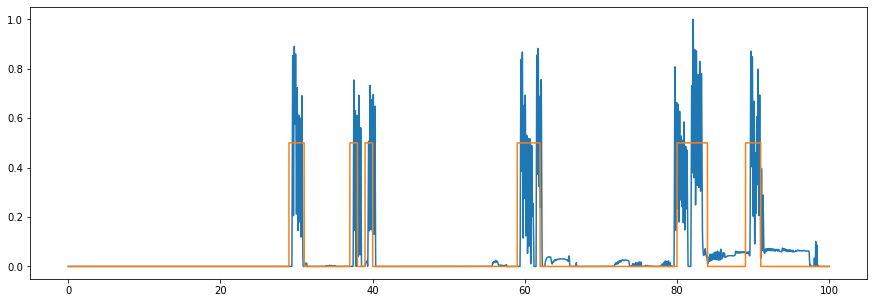

In [21]:
j = 0
binary_test_signal = np.zeros(sub1_eval['test_dg'].shape)
for j in range(0,5):
    binary_test_signal[:, j] = binary_activation(sub1_eval['test_dg'][:, j], threshold = 400) # threshold between 300 and 400
    
    fig = plt.pyplot.figure(figsize=(15,5))
    x = np.linspace(0, 100, 200000)
    plt.pyplot.plot(x, sub1_eval['test_dg'][:, j])
    plt.pyplot.plot(x, binary_test_signal[:, j])

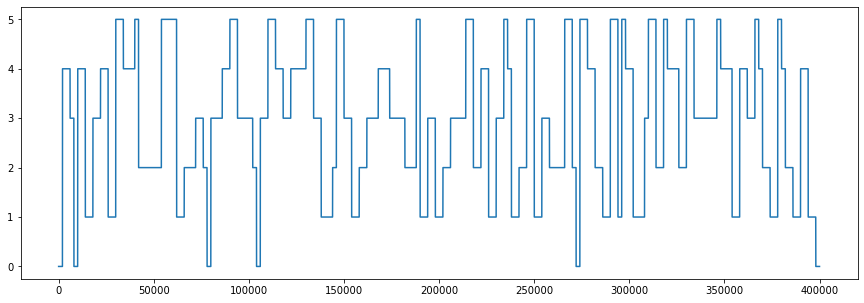

In [22]:
## Generating the target training vector to which we will train the model
target_training_vector = np.zeros(sub1['train_dg'][:, 0].shape)
length = target_training_vector.shape[0]
i = 0
j = 0
# for i in range(0, 5):
#     target_vector[binary_signal[:, i] > 0] = i+1
    
stride = 1000 # stride is important as it defines the batch size to send into the model
for j in range(0, length-stride, stride):
    max_count = np.count_nonzero(binary_signal[j:j+stride, 0] > 0)
    value_setter = 0+1
    for i in range(1, 5):
        if np.count_nonzero(binary_signal[j:j+stride, i] > 0) > max_count:
            max_count = np.count_nonzero(binary_signal[j:j+stride, i] > 0)
            value_setter = i+1
    
    if max_count > 500:
        target_training_vector[j:j+stride] = value_setter
    else:
        target_training_vector[j:j+stride] = 0
    
fig = plt.pyplot.figure(figsize = (15, 5))
plt.pyplot.plot(target_training_vector)


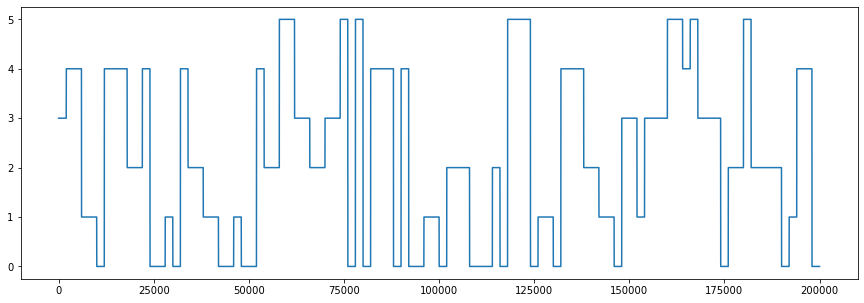

In [23]:
## Generating the target test vector to which we will train the model
target_test_vector = np.zeros(sub1_eval['test_dg'][:, 0].shape)
length = target_test_vector.shape[0]
i = 0
j = 0
    
stride = 1000 # stride is important as it defines the batch size to send into the model
for j in range(0, length-stride, stride):
    max_count = np.count_nonzero(binary_test_signal[j:j+stride, 0] > 0)
    value_setter = 0+1
    for i in range(1, 5):
        if np.count_nonzero(binary_test_signal[j:j+stride, i] > 0) > max_count:
            max_count = np.count_nonzero(binary_test_signal[j:j+stride, i] > 0)
            value_setter = i+1
    
    if max_count > 500:
        target_test_vector[j:j+stride] = value_setter
    else:
        target_test_vector[j:j+stride] = 0
    
fig = plt.pyplot.figure(figsize = (15, 5))
plt.pyplot.plot(target_test_vector)


In [24]:
def clean_edges(time_signal):
        freq_signal = rfft(time_signal)
        freq_x = fftfreq(time_signal.size, 1/1000)
        
        freq_signal[(np.abs(freq_x) < 0.15) | (np.abs(freq_x) > 200)] = 0
        
        time_signal = irfft(freq_signal)
        return time_signal

In [25]:
### Filtering the ECoG signals to more specific bands ###

def signal_filter(time_signal):
    # fig = plt.pyplot.figure(figsize=(20,10))
    freq_signal = rfft(time_signal)
    freq_x = fftfreq(time_signal.size, 1/1000)

    # plt.pyplot.plot(freq_x, np.abs(freq_signal))

    # Removing any inconsistency in the signal when bandpassed between 0.15 and 200 during measurement
    freq_signal[(np.abs(freq_x) < 0.15) | (np.abs(freq_x) > 200)] = 0
    
    # Dividing the ECoG channel signal into 3 specific bands (Sanchez et. al)
    
    # sub_band = freq_signal[(np.abs(freq_x) >= 1) & (np.abs(freq_x) < 60)]
    sub_band = freq_signal
    sub_band[(np.abs(freq_x) < 1) | (np.abs(freq_x) > 60)] = 0
    
    # gamma_band = freq_signal[(np.abs(freq_x) >= 60) & (np.abs(freq_x) < 100)]
    gamma_band = freq_signal
    gamma_band[(np.abs(freq_x) <= 60) | (np.abs(freq_x) > 100)] = 0
    
    # fast_gamma_band = freq_signal[(np.abs(freq_x) >= 100) & (np.abs(freq_x) <= 200)]
    fast_gamma_band = freq_signal
    fast_gamma_band[(np.abs(freq_x) <= 100) | (np.abs(freq_x) > 200)] = 0

    sub_band_time = irfft(sub_band)
    gamma_band_time = irfft(gamma_band)
    fast_gamma_band_time = irfft(fast_gamma_band)

    # One thing you will notice is that the 3 time series bands when appended together will have considerably less data...
    # ... than the original signal while retaining all its information
    
    # cleaned_signal = irfft(freq_signal)
    return (sub_band_time, gamma_band_time, fast_gamma_band_time)

In [26]:
i = 0
for i in range(0, sub1['train_data'].shape[1]):
    sub1['train_data'][:, i] = clean_edges(sub1['train_data'][:, i])
    sub1['test_data'][:, i] = clean_edges(sub1['test_data'][:, i])

In [27]:
## Now we want to create the training data and the validation data. Split by putting 300s into training and 100s in validation

C = sub1['train_data'].shape[1] # Number of ECoG signal channels
sub1_training_data = np.zeros((400, 1, 1000, C))
sub1_training_labels = np.zeros((400, 1))

sub1_test_data = np.zeros((200, 1, 1000, C))
sub1_test_labels = np.zeros((200, 1))


i = 0
for i in range(0, 400):
    sub1_training_data[i] = [sub1['train_data'][i*1000:i*1000+1000, :]]
    sub1_training_labels[i] = [target_training_vector[i*1000+500]]

i = 0
for i in range(0, 200):
    sub1_test_data[i] = [sub1['test_data'][i*1000:i*1000+1000, :]]
    sub1_test_labels[i] = [target_test_vector[i*1000+500]]

In [28]:
model = keras.models.Sequential()

# Spatial Convolution Layer
model.add(keras.layers.Conv2D(1, (C, C), activation='relu', data_format='channels_first', input_shape=(1, 1000, C), padding='same'))
# Batch size is 1, sending one window of 1s data one at a time
# Temporal Covolutional Layer
model.add(keras.layers.Conv2D(2, (1, 17), activation='relu', data_format='channels_first', input_shape=(1, 1000, C), padding='same'))
model.add(keras.layers.Conv2D(4, (1, 17), activation='relu', data_format='channels_first', input_shape=(1, 1000, C), padding='same'))
model.add(keras.layers.Conv2D(8, (1, 17), activation='relu', data_format='channels_first', input_shape=(1, 1000, C), padding='same'))

# Pooling Layer ??

In [29]:
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(16, activation='softmax'))
model.add(keras.layers.Dense(8, activation='softmax'))
model.add(keras.layers.Dense(6)) # Output layer

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 1000, 61)       3722      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 1000, 61)       36        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 1000, 61)       140       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 1000, 61)       552       
_________________________________________________________________
flatten (Flatten)            (None, 488000)            0         
_________________________________________________________________
dense (Dense)                (None, 8)                 3904008   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 5

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
history = model.fit(sub1_training_data, sub1_training_labels, epochs=200, 
                    validation_split=0.25, verbose=1)

Epoch 1/200
10/10 [==============================] - 20s 839ms/step - loss: 1.7430 - accuracy: 0.1767 - val_loss: 1.7324 - val_accuracy: 0.1800
Epoch 2/200
10/10 [==============================] - 4s 362ms/step - loss: 1.7328 - accuracy: 0.2467 - val_loss: 1.7307 - val_accuracy: 0.1800
Epoch 3/200
10/10 [==============================] - 4s 360ms/step - loss: 1.7303 - accuracy: 0.2467 - val_loss: 1.7289 - val_accuracy: 0.1800
Epoch 4/200
10/10 [==============================] - 4s 362ms/step - loss: 1.7276 - accuracy: 0.2467 - val_loss: 1.7274 - val_accuracy: 0.1800
Epoch 5/200
10/10 [==============================] - 4s 362ms/step - loss: 1.7254 - accuracy: 0.2467 - val_loss: 1.7256 - val_accuracy: 0.1800
Epoch 6/200
10/10 [==============================] - 4s 362ms/step - loss: 1.7233 - accuracy: 0.2467 - val_loss: 1.7242 - val_accuracy: 0.1800
Epoch 7/200
10/10 [==============================] - 4s 362ms/step - loss: 1.7212 - accuracy: 0.2467 - val_loss: 1.7231 - val_accuracy: 0.180

Epoch 58/200
10/10 [==============================] - 4s 403ms/step - loss: 1.6927 - accuracy: 0.2467 - val_loss: 1.7069 - val_accuracy: 0.1800
Epoch 59/200
10/10 [==============================] - 4s 403ms/step - loss: 1.6926 - accuracy: 0.2467 - val_loss: 1.7068 - val_accuracy: 0.1800
Epoch 60/200
10/10 [==============================] - 4s 403ms/step - loss: 1.6925 - accuracy: 0.2467 - val_loss: 1.7067 - val_accuracy: 0.1800
Epoch 61/200
10/10 [==============================] - 4s 403ms/step - loss: 1.6924 - accuracy: 0.2467 - val_loss: 1.7066 - val_accuracy: 0.1800
Epoch 62/200
10/10 [==============================] - 4s 403ms/step - loss: 1.6923 - accuracy: 0.2467 - val_loss: 1.7069 - val_accuracy: 0.1800
Epoch 63/200
10/10 [==============================] - 4s 402ms/step - loss: 1.6923 - accuracy: 0.2467 - val_loss: 1.7065 - val_accuracy: 0.1800
Epoch 64/200
10/10 [==============================] - 4s 402ms/step - loss: 1.6922 - accuracy: 0.2467 - val_loss: 1.7068 - val_accuracy:

Epoch 115/200
10/10 [==============================] - 4s 403ms/step - loss: 1.6910 - accuracy: 0.2467 - val_loss: 1.7062 - val_accuracy: 0.1800
Epoch 116/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6910 - accuracy: 0.2467 - val_loss: 1.7063 - val_accuracy: 0.1800
Epoch 117/200
10/10 [==============================] - 4s 403ms/step - loss: 1.6911 - accuracy: 0.2467 - val_loss: 1.7061 - val_accuracy: 0.1800
Epoch 118/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6911 - accuracy: 0.2467 - val_loss: 1.7062 - val_accuracy: 0.1800
Epoch 119/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6910 - accuracy: 0.2467 - val_loss: 1.7059 - val_accuracy: 0.1800
Epoch 120/200
10/10 [==============================] - 4s 403ms/step - loss: 1.6911 - accuracy: 0.2467 - val_loss: 1.7059 - val_accuracy: 0.1800
Epoch 121/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6911 - accuracy: 0.2467 - val_loss: 1.7059 - val_ac

10/10 [==============================] - 4s 404ms/step - loss: 1.6910 - accuracy: 0.2467 - val_loss: 1.7073 - val_accuracy: 0.1800
Epoch 172/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6910 - accuracy: 0.2467 - val_loss: 1.7073 - val_accuracy: 0.1800
Epoch 173/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6911 - accuracy: 0.2467 - val_loss: 1.7069 - val_accuracy: 0.1800
Epoch 174/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6909 - accuracy: 0.2467 - val_loss: 1.7067 - val_accuracy: 0.1800
Epoch 175/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6910 - accuracy: 0.2467 - val_loss: 1.7064 - val_accuracy: 0.1800
Epoch 176/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6909 - accuracy: 0.2467 - val_loss: 1.7067 - val_accuracy: 0.1800
Epoch 177/200
10/10 [==============================] - 4s 404ms/step - loss: 1.6909 - accuracy: 0.2467 - val_loss: 1.7067 - val_accuracy: 0.1800

In [34]:
# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
# print(test_acc)